### PART 3-CASE STUDY HEALTHCARE DATA ANALYSIS  

 Identify 10,000 Medicare patients who were involved in anomalous activities

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import pandas_profiling
%matplotlib inline

In [72]:
Patient_history = pd.read_csv('Patient_history_samp.csv')
Review_patient = pd.read_csv('Review_patient_history_samp.csv')
Review_transaction = pd.read_csv('Rreview_transaction_coo.csv')
Transaction = pd.read_csv('Transaction_coo.csv')

    #2. Data Analysis and Data Preparation

    Generally for anomaly detection, we aim to learn what is most representative of ‘normal’, 
    then anything outside of some threshold can be considered an anomaly
    
    Review_patient_history_samp.csv and Rreview_transaction_coo.csv datasets are the details for reviewed patient.
    Patient_history_samp.csv and Transaction_coo.csv are unclassified patient.
    
    We have to identify the cause/pattern for the review patient and based on that the unmarked patients needs to be marked.

In [73]:
Patient_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
id        500000 non-null int64
age       497470 non-null object
gender    500000 non-null object
income    497469 non-null object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


In [74]:
Patient_history.shape[0]-Patient_history.count()

id           0
age       2530
gender       0
income    2531
dtype: int64

In [81]:
Review_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
id        5000 non-null int64
age       4974 non-null object
gender    5000 non-null object
income    4974 non-null object
dtypes: int64(1), object(3)
memory usage: 156.3+ KB


In [87]:
Transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514809 entries, 0 to 1514808
Data columns (total 3 columns):
id                1514809 non-null int64
global_proc_id    1514809 non-null int64
count             1514809 non-null int64
dtypes: int64(3)
memory usage: 34.7 MB


In [120]:
Transaction.head()

,id,global_proc_id,count
0,159125,1,1
1,191852,1,1
2,321083,1,1
3,383037,1,1
4,467729,1,1


In [89]:
Review_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15041 entries, 0 to 15040
Data columns (total 3 columns):
id                15041 non-null int64
global_proc_id    15041 non-null int64
count             15041 non-null int64
dtypes: int64(3)
memory usage: 352.6 KB


In [82]:
Patient_history.groupby('gender')['id'].nunique()

gender
F    274512
M    225488
Name: id, dtype: int64

In [83]:
Patient_history.groupby('income')['id'].nunique()

income
16000-23999    102492
24000-31999     75670
32000-47999     95899
48000+         115865
<16000         107543
Name: id, dtype: int64

In [84]:
Patient_history.groupby('age')['id'].nunique()

age
65-74    219329
75-84    128992
85+       64581
<65       84568
Name: id, dtype: int64

In [85]:
Review_patient.groupby('age')['id'].nunique()

age
65-74    2188
75-84    1247
85+       655
<65       884
Name: id, dtype: int64

 Missing value imputation and Transforming categorical variables to numerical variables (grouping) for better data preprocesing
    and dropping the categorical variables

In [94]:
def Missing_imputation(x):
    x = x.fillna(x.mode().iloc[0])
    return x

Review_patient=Review_patient.apply(lambda x: Missing_imputation(x))
Patient_history=Patient_history.apply(lambda x: Missing_imputation(x))

In [95]:
Patient_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
id        500000 non-null int64
age       500000 non-null object
gender    500000 non-null object
income    500000 non-null object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


In [96]:
Review_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
id        5000 non-null int64
age       5000 non-null object
gender    5000 non-null object
income    5000 non-null object
dtypes: int64(1), object(3)
memory usage: 156.3+ KB


In [97]:
feature=Patient_history.columns.difference(['id'])
feature

Index(['age', 'gender', 'income'], dtype='object')

In [98]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [99]:
feature_list=list(Patient_history.columns.difference(['id']))

for c_feature in feature_list:
    Patient_history[c_feature] = Patient_history[c_feature].astype('category')
    Patient_history = create_dummies(Patient_history, c_feature )
    Review_patient[c_feature] = Review_patient[c_feature].astype('category')
    Review_patient = create_dummies(Review_patient , c_feature )
      

In [100]:
Patient_history.columns

Index(['id', 'age_75-84', 'age_85+', 'age_<65', 'gender_M',
       'income_24000-31999', 'income_32000-47999', 'income_48000+',
       'income_<16000'],
      dtype='object')

In [101]:
Patient_history.rename(columns={'age_75-84':'age_2', 'age_85+':'age_3', 'age_<65':'age_1', 'income_24000-31999':'income_2', 'income_32000-47999':'income_3', 'income_48000+':'income_4','income_<16000':'income_1'},inplace=True)

       

In [102]:
Review_patient.rename(columns={'age_75-84':'age_2', 'age_85+':'age_3', 'age_<65':'age_1', 'income_24000-31999':'income_2', 'income_32000-47999':'income_3', 'income_48000+':'income_4','income_<16000':'income_1'},inplace=True)

In [155]:
Patient_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
id          500000 non-null int64
age_2       500000 non-null uint8
age_3       500000 non-null uint8
age_1       500000 non-null uint8
gender_M    500000 non-null uint8
income_2    500000 non-null uint8
income_3    500000 non-null uint8
income_4    500000 non-null uint8
income_1    500000 non-null uint8
dtypes: int64(1), uint8(8)
memory usage: 7.6 MB


In [156]:
Review_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
id          5000 non-null int64
age_2       5000 non-null uint8
age_3       5000 non-null uint8
age_1       5000 non-null uint8
gender_M    5000 non-null uint8
income_2    5000 non-null uint8
income_3    5000 non-null uint8
income_4    5000 non-null uint8
income_1    5000 non-null uint8
dtypes: int64(1), uint8(8)
memory usage: 78.2 KB


In [123]:
col_dummies=pd.get_dummies(Transaction['global_proc_id'], prefix='proc')
Transaction_cat = pd.concat([Transaction, col_dummies], axis=1)
Transaction_cat.drop( 'global_proc_id', axis = 1, inplace = True )

In [127]:
Transction_grp=Transaction_cat.groupby('id').agg('sum').reset_index()

In [130]:
Transction_grp.head()

,id,count,proc_1,proc_2,proc_3,proc_4,proc_5,proc_6,proc_7,proc_8,...,proc_121,proc_122,proc_123,proc_124,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130
0,7561,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7619,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10479,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13515,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15213,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
Transction_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505000 entries, 0 to 504999
Columns: 132 entries, id to proc_130
dtypes: int64(2), uint8(130)
memory usage: 70.3 MB


In [145]:
patient_dataset = Transction_grp.merge(Patient_history,on='id', how='left')

    For review dataset - labeled

In [146]:
col_dummies=pd.get_dummies(Review_transaction['global_proc_id'], prefix='proc')
Review_transaction_cat = pd.concat([Review_transaction, col_dummies], axis=1)
Review_transaction_cat.drop( 'global_proc_id', axis = 1, inplace = True )

In [147]:
Review_Transaction_grp=Review_transaction_cat.groupby('id').agg('sum').reset_index()


In [148]:
Review_Transaction_grp.head()

,id,count,proc_1,proc_2,proc_3,proc_5,proc_6,proc_7,proc_8,proc_9,...,proc_121,proc_122,proc_123,proc_124,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130
0,65822,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,119695,3,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,131488,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,360915,3,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,389225,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
# Review dataset do not have patient opting for proc 4 - hence creating a dummy column with all zeros
Review_Transaction_grp['proc_4'] = 0

In [150]:
review_dataset = Review_Transaction_grp.merge(Review_patient,on='id', how='left')

    Adding flag to the review and unmarked datasets

In [151]:
patient_dataset['review_ind'] = 0

In [152]:
review_dataset['review_ind'] = 1

In [159]:
patient_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505000 entries, 0 to 504999
Columns: 141 entries, id to review_ind
dtypes: float64(8), int64(3), uint8(130)
memory usage: 108.8 MB


In [161]:
review_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Columns: 141 entries, id to review_ind
dtypes: int64(4), uint8(137)
memory usage: 864.3 KB


    Aligning the data type - int64 to all dummy variables

In [164]:
patient_dataset.dropna(axis=0, how='any', inplace = True)
review_dataset.dropna(axis=0, how='any', inplace = True)

In [165]:
list1 = patient_dataset.columns.difference(['id','review_ind','count'])

In [166]:
patient_dataset[list1] = patient_dataset[list1].astype('int64')
review_dataset[list1] = review_dataset[list1].astype('int64')

In [167]:
patient_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 504999
Columns: 141 entries, id to review_ind
dtypes: int64(141)
memory usage: 541.7 MB


In [168]:
review_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Columns: 141 entries, id to review_ind
dtypes: int64(141)
memory usage: 5.4 MB


In [169]:
patient_dataset['id'].count()

500000

In [170]:
review_dataset['id'].count()

5000

    So at this moment we have 500000 unmarked patients and 5000 marked (review) patient.
    This is an imbalanced data.
    
    We have to create a model by sampling out data from unmarked dataset  get  a balanced data.
   

In [172]:
sample_dataset = patient_dataset.sample(frac=0.1)

In [173]:
frames = [sample_dataset, review_dataset]
train_df = pd.concat(frames)

C:\Users\arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [174]:
cols = train_df.columns.difference( ['review_ind', 'id'] )

In [176]:
df_train = train_df[cols ]
df_test = patient_dataset[cols ]

In [179]:
from sklearn.model_selection import train_test_split


train_X, test_X, train_Y, test_Y = train_test_split( train_df[cols ],
                                                  train_df['review_ind'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

In [203]:
clf = RandomForestClassifier(n_estimators=50 )
clf.fit(train_X,train_Y)

# Make predictions for train and test dataset
predictions_train = clf.predict(train_X)
probs_train = clf.predict_proba(train_X)
predictions = clf.predict(df_test[cols])
probs = clf.predict_proba(df_test[cols])
display(predictions)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [204]:
score = clf.score(train_X,train_Y)
print("Accuracy: ", score)

Accuracy:  0.9945681818181819


Text(0.5, 15.0, 'Predicted label')

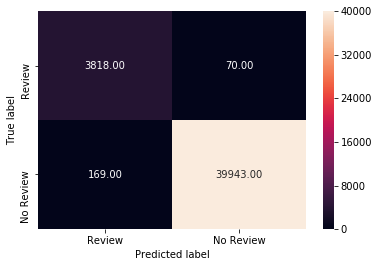

In [205]:
tree_cm = metrics.confusion_matrix( predictions_train,
                                 train_Y, [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Review", "No Review"] , yticklabels = ["Review", "No Review"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [215]:
#Predicting the test cases
predictions_train_df = pd.DataFrame( { 'actual':  train_Y,
                            'predicted': predictions_train } ).reset_index(drop=True)

In [216]:
predictions_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44000 entries, 0 to 43999
Data columns (total 2 columns):
actual       44000 non-null int64
predicted    44000 non-null int64
dtypes: int64(2)
memory usage: 687.6 KB


In [217]:
predictions_train_df.head()

,actual,predicted
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0


In [218]:
probs_train_df = pd.DataFrame(probs_train)

In [219]:
probs_train_df.head()

,0,1
0,1.000000,0.000000
1,1.000000,0.000000
2,0.119714,0.880286
3,1.000000,0.000000
4,0.980000,0.020000


In [220]:
probs_train_df.columns=['review_0','review_1']

In [221]:
train_pred = pd.concat( [predictions_train_df, probs_train_df], axis = 1 )

In [222]:
train_pred.head()

,actual,predicted,review_0,review_1
0,0,0,1.000000,0.000000
1,0,0,1.000000,0.000000
2,1,1,0.119714,0.880286
3,0,0,1.000000,0.000000
4,0,0,0.980000,0.020000


In [249]:
df_test=patient_dataset.copy()

In [251]:
#Score for test Datasets
score = clf.score(df_test[cols], patient_dataset["review_ind"])
print("Accuracy: ", score)

Accuracy:  0.982732


In [231]:
(1 -.982732)*500000

8633.999999999975

     ###    There are 8634 patient who are showing as anomolous -REVIEW_ID predicted as 1 (having prediction prob > 0.5)
    

    Adding test probabilities with test datasets

In [252]:
df_test["prob_true"] = probs[:, 1]

In [254]:
df_anomalous= df_test[df_test["prob_true"] > 0.5 ]
df_anomalous["prob_true"].count()

8634

In [255]:
df_anomalous.head()

,id,count,proc_1,proc_2,proc_3,proc_4,proc_5,proc_6,proc_7,proc_8,...,age_2,age_3,age_1,gender_M,income_2,income_3,income_4,income_1,review_ind,prob_true
14,28504,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0.72
63,126180,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.52
91,176428,2,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0.60
127,252926,2,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0.70
148,295270,2,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0.52


  Refining the anomalous patient by K-MEANS Cluster Analysis

    Using clustering determine the anomany -
    
    A. Feature importance - Using Recursive feature elmination (top 20).
    B. Using K-MEANS to check if the anomolous participants are clustering together.

    KMEANS gives us the suspicious/anamalous patients are getting clustered at Cluster 0  and Cluster 3 

#### Cluster Analysis -

   ![cluster 5](cluster5ouput.png)

In [256]:
indices = np.argsort(clf.feature_importances_)[::-1]

In [236]:
#Using Recursive feature elmination


from sklearn.feature_selection import RFE


rfc = RandomForestClassifier()

# create the RFE model and select 20 attributes
rfe = RFE(rfc, n_features_to_select=20)
rfe = rfe.fit(train_X,train_Y)



C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

In [237]:
col = train_X.columns[rfe.get_support()] 

In [238]:
col

Index(['count', 'proc_122', 'proc_124', 'proc_13', 'proc_17', 'proc_19',
       'proc_2', 'proc_20', 'proc_25', 'proc_26', 'proc_27', 'proc_28',
       'proc_3', 'proc_34', 'proc_52', 'proc_53', 'proc_58', 'proc_83',
       'proc_97', 'proc_99'],
      dtype='object')

    Preparing Data -
    Merging the anomalous data with review data to check if patients are comming together in specific clusters

In [257]:
df_subdata = df_anomalous.drop('prob_true', axis =1)

In [258]:
frames = [df_subdata, review_dataset]
medi_data = pd.concat(frames)

C:\Users\arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [259]:
medi_data.head()

,age_1,age_2,age_3,count,gender_M,id,income_1,income_2,income_3,income_4,...,proc_91,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99,review_ind
14,0,1,0,3,0,28504,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,0,0,0,4,0,126180,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,0,0,1,2,0,176428,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
127,0,1,0,2,1,252926,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
148,0,0,1,2,1,295270,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [260]:
analysis_data = medi_data[col]

In [261]:
analysis_data.head()

,count,proc_122,proc_124,proc_13,proc_17,proc_19,proc_2,proc_20,proc_25,proc_26,proc_27,proc_28,proc_3,proc_34,proc_52,proc_53,proc_58,proc_83,proc_97,proc_99
14,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
63,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
127,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
148,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [262]:
col_list = analysis_data.columns

In [263]:
col_list

Index(['count', 'proc_122', 'proc_124', 'proc_13', 'proc_17', 'proc_19',
       'proc_2', 'proc_20', 'proc_25', 'proc_26', 'proc_27', 'proc_28',
       'proc_3', 'proc_34', 'proc_52', 'proc_53', 'proc_58', 'proc_83',
       'proc_97', 'proc_99'],
      dtype='object')

#### Standardizing the data

In [264]:
from sklearn.preprocessing import StandardScaler

In [265]:
sc=StandardScaler()

In [266]:
analysis_scaled=sc.fit_transform(analysis_data)

C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Applying PCA

In [267]:
from sklearn.decomposition import PCA

In [268]:

for n in range(2,20):
    pc = PCA(n_components=n)
    analysis_pca=pc.fit(analysis_scaled)
   

In [269]:
np.cumsum(pc.explained_variance_ratio_)

array([0.07279509, 0.13092087, 0.18679337, 0.241492  , 0.29503802,
       0.34834944, 0.40131168, 0.45296263, 0.50378955, 0.55446804,
       0.6041349 , 0.65308964, 0.70131642, 0.74910631, 0.79627286,
       0.84274812, 0.88853126, 0.93284286, 0.97243452])

In [270]:
# 17 component is defining 84% of variability
pc_final=PCA(n_components=17).fit(analysis_scaled)
reduced_cr=pc_final.fit_transform(analysis_scaled)

In [271]:
reduced_cr.shape

(13634, 17)

In [273]:
pd.DataFrame(pc_final.components_.T, columns=['PC_' + str(i) for i in range(17)], index=col_list)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16
count,0.662551,0.213948,-0.051908,-0.019750,-0.018802,-0.041404,0.006526,-0.051656,0.006183,0.048642,-0.034808,-0.012049,0.057790,0.022913,-0.051391,0.075290,-0.108938
proc_122,0.279661,-0.201232,0.274767,0.044673,-0.051234,-0.041804,0.388461,-0.296318,-0.311766,0.061930,-0.068014,-0.053072,-0.301768,-0.134304,0.093789,0.092587,0.390898
proc_124,0.161376,0.218566,0.353668,-0.526201,-0.078204,-0.053294,-0.273943,-0.064246,0.152276,-0.111743,0.058670,-0.058301,0.168042,0.262447,0.238868,0.294924,-0.068707
proc_13,0.217911,0.091164,0.040113,-0.004541,-0.266912,-0.006025,0.206179,0.446816,0.043986,-0.247843,0.033520,-0.285795,-0.476758,-0.068645,0.283081,-0.172237,-0.289364
proc_17,0.264753,-0.454158,0.188913,0.160294,0.020417,-0.021725,0.185363,-0.094551,-0.207131,-0.051688,-0.066774,0.002731,0.409712,0.153732,0.078220,0.132254,-0.263070
proc_19,0.336569,-0.184977,-0.231406,-0.150625,0.002734,0.075331,-0.378914,0.021732,0.181702,0.014018,-0.185374,0.125304,-0.194606,-0.170672,-0.057584,-0.090554,0.458946
proc_2,0.099342,0.183318,-0.034755,0.043752,-0.272498,0.057980,0.156650,0.167449,-0.132157,-0.484191,0.450533,0.333549,0.289180,0.023865,-0.093284,-0.061390,0.384991
proc_20,0.089248,0.089539,-0.035426,-0.213378,0.022860,0.431886,-0.171520,0.037479,-0.392441,0.197810,0.039495,-0.478842,0.287230,-0.145735,0.092783,-0.264889,0.133924
proc_25,0.085897,-0.013447,0.061359,0.108329,-0.103080,-0.023868,0.022474,-0.132970,0.277361,0.548931,0.716261,-0.048655,-0.088836,-0.057425,0.065506,0.062408,0.011249
proc_26,0.100282,0.129053,-0.223739,0.010438,0.302162,-0.384752,-0.043069,0.052561,-0.317385,0.132735,0.089471,0.007383,-0.159274,0.653416,0.075840,-0.239929,0.131354


#### Clustering

#### Silhouette Coefficient

In [274]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [275]:
# calculate SC for K=3 through K=15
k_range = range(3, 15)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(analysis_scaled)
    scores.append(metrics.silhouette_score(analysis_scaled, km.labels_))

In [276]:
scores

[0.3918799711266425,
 0.5053771528536366,
 0.25141313991768566,
 0.3248275790609664,
 0.2742762888894323,
 0.2604860591001024,
 0.2962450827425851,
 0.2787917615753448,
 0.3382146460738018,
 0.3331635765302923,
 0.3588623296396251,
 0.3719841837308669]

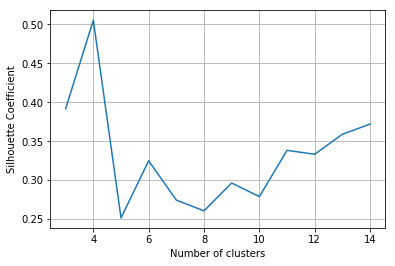

In [277]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

    Silhouette Coefficient shows 5 Cluster should optimal

In [278]:
km_5=KMeans(init='k-means++', n_clusters=5,random_state=123)

In [279]:
km_5.fit(reduced_cr)
km_5.labels_

array([0, 3, 0, ..., 0, 0, 0])

In [280]:
pd.Series(km_5.labels_).value_counts()

0    11740
3     1299
4      537
1       40
2       18
dtype: int64

In [282]:
km_5 = pd.DataFrame(km_5.labels_)

In [283]:
km_5.count()

0    13634
dtype: int64

In [284]:
medi_data = medi_data.reset_index()

In [285]:
cluster_df_5= pd.concat([medi_data, km_5], axis=1)

In [286]:
cluster_df_5.rename(columns={0: 'KMEANS_5'}, inplace=True)

In [287]:
cluster_df_5.to_csv('final_cluster_df_5.csv')

In [288]:
cluster_df_5.head()

,index,age_1,age_2,age_3,count,gender_M,id,income_1,income_2,income_3,...,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99,review_ind,KMEANS_5
0,14,0,1,0,3,0,28504,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,0,0,0,4,0,126180,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,91,0,0,1,2,0,176428,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,127,0,1,0,2,1,252926,0,0,1,...,0,0,0,0,0,1,0,0,0,3
4,148,0,0,1,2,1,295270,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [290]:
cluster_to_audit = cluster_df_5[['id', 'review_ind', 'KMEANS_5']]

In [291]:
cluster_to_audit.head()

,id,review_ind,KMEANS_5
0,28504,0,0
1,126180,0,3
2,176428,0,0
3,252926,0,3
4,295270,0,0


In [292]:
cluster_to_audit.to_csv('cluster_to_audit.csv')

In [306]:
km_8=KMeans(init='k-means++', n_clusters=8,random_state=12)

In [307]:

km_8.fit(reduced_cr)
km_8.labels_

array([1, 0, 1, ..., 1, 7, 1])

In [308]:
pd.Series(km_8.labels_).value_counts()

1    10098
7     1862
0     1278
5      210
2      114
3       41
6       18
4       13
dtype: int64